## Graph state - entanglement

In [49]:
## import necessary packages
import sys
import numpy as np
import matplotlib as mpl
import math
from cmath import cos, sin, exp, pi
# import cmath


import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 400
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import random
pauli_operators = [qeye(2), sigmax(),sigmay(),sigmaz()]
I, X, Y, Z = qeye(2), sigmax(), sigmay(), sigmaz()


from sklearn import svm, datasets
from sklearn.inspection import DecisionBoundaryDisplay


from qutip import *
# https://qutip-qip.readthedocs.io/en/stable/qip-simulator.html#
from qutip_qip.circuit import QubitCircuit
# https://qutip-qip.readthedocs.io/en/stable/qip-basics.html
from qutip_qip.operations import (Gate, controlled_gate, hadamard_transform, sqrtswap)


def generate_zero_state(n):
    return tensor([basis(2,0) for i in range(n)])


### Graph state - ring

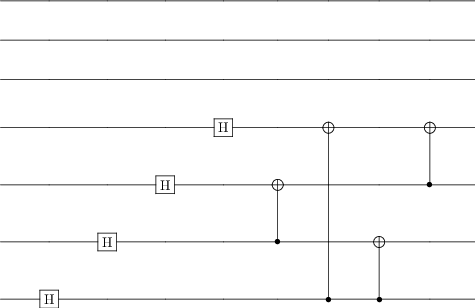

In [46]:
# https://qutip-qip.readthedocs.io/en/stable/qip-simulator.html#
qc_ring = QubitCircuit(N=4, num_cbits=3)
qc_ring.add_gate("SNOT", targets=[0])
qc_ring.add_gate("SNOT", targets=[1])
qc_ring.add_gate("SNOT", targets=[2])
qc_ring.add_gate("SNOT", targets=[3])
qc_ring.add_gate("CZ", targets=[2], controls=1)
qc_ring.add_gate("CZ", targets=[3], controls=0)
qc_ring.add_gate("CZ", targets=[1], controls=0)
qc_ring.add_gate("CZ", targets=[3], controls=2)
qc_ring.png

In [47]:
zero_state = generate_zero_state(4)
ring_state = qc_ring.run(state=zero_state)

print(ring_state)

Quantum object: dims = [[2, 2, 2, 2], [1, 1, 1, 1]], shape = (16, 1), type = ket
Qobj data =
[[ 0.25]
 [ 0.25]
 [ 0.25]
 [-0.25]
 [ 0.25]
 [ 0.25]
 [-0.25]
 [ 0.25]
 [ 0.25]
 [-0.25]
 [ 0.25]
 [ 0.25]
 [-0.25]
 [ 0.25]
 [ 0.25]
 [ 0.25]]


### SQRT-SWAP

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0.5+0.5j 0.5-0.5j 0. +0.j ]
 [0. +0.j  0.5-0.5j 0.5+0.5j 0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  1. +0.j ]]


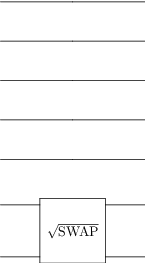

In [50]:
print(sqrtswap())

qc_sqrtswap = QubitCircuit(N=4, num_cbits=3)
# Square root of the SWAP gate
# qc_sqrtswap.add_gate("TOFFOLI", targets=[2], controls=[0, 1])
qc_sqrtswap.add_gate("SQRTSWAP", targets=[0,1])
qc_sqrtswap.png

In [51]:
result = qc_sqrtswap.run(state=tensor(basis(2, 0), basis(2, 0), basis(2, 0), basis(2, 0)))
print(result)

Quantum object: dims = [[2, 2, 2, 2], [1, 1, 1, 1]], shape = (16, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


### Generate W states

/Users/jue/opt/anaconda3/lib/python3.8/site-packages/qutip_qip/operations/gates.py:463: UserWarning: Unknown gate cH
  warnings.warn("Unknown gate %s" % name)


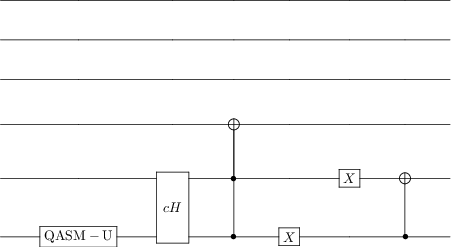

In [52]:

def controlled_hadamard():
    # Controlled Hadamard
    return controlled_gate(hadamard_transform(1),
                           2,
                           control=0,
                           target=1,
                           control_value=1)


qc_w = QubitCircuit(N=3, num_cbits=3)
qc_w.user_gates = {"cH": controlled_hadamard}
# U rotation gate used as a primitive in the QASM standard
qc_w.add_gate("QASMU", targets=[0], arg_value=[1.91063, 0, 0])
qc_w.add_gate("cH", targets=[0, 1])
qc_w.add_gate("TOFFOLI", targets=[2], controls=[0, 1])
qc_w.add_gate("X", targets=[0])
qc_w.add_gate("X", targets=[1])
qc_w.add_gate("CNOT", targets=[1], controls=0)
qc_w.png


In [53]:
# qc.add_measurement("M0", targets=[0], classical_store=0)
# qc.add_measurement("M1", targets=[1], classical_store=1)
# qc.add_measurement("M2", targets=[2], classical_store=2)

# from qutip import tensor, basis

zero_state = tensor(basis(2, 0), basis(2, 0), basis(2, 0))
wstate = qc_w.run(state=zero_state)

print(wstate)
print(w_state(3))

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.        ]
 [0.57734961]
 [0.57734961]
 [0.        ]
 [0.57735159]
 [0.        ]
 [0.        ]
 [0.        ]]
Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.        ]
 [0.57735027]
 [0.57735027]
 [0.        ]
 [0.57735027]
 [0.        ]
 [0.        ]
 [0.        ]]


### Custom Gates

In [54]:
# https://qutip-qip.readthedocs.io/en/stable/qip-basics.html
from qutip_qip.operations import Gate, rx


def user_gate1(arg_value):
    # controlled rotation X
    mat = np.zeros((4, 4), dtype=np.complex128)
    mat[0, 0] = mat[1, 1] = 1.
    mat[2:4, 2:4] = rx(arg_value)
    return Qobj(mat, dims=[[2, 2], [2, 2]])


def user_gate2():
    # S gate
    mat = np.array([[1., 0], [0., 1.j]])
    return Qobj(mat, dims=[[2], [2]])


qc = QubitCircuit(2)
qc.user_gates = {"CTRLRX": user_gate1, "S": user_gate2}

# qubit 0 controls qubit 1
qc.add_gate("CTRLRX", targets=[0, 1], arg_value=np.pi / 2)

# qubit 1 controls qubit 0
qc.add_gate("CTRLRX", targets=[1, 0], arg_value=np.pi / 2)

# we also add a gate using a predefined Gate object
g_T = Gate("S", targets=[1])
qc.add_gate(g_T)
props = qc.propagators()

print(props[0])

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         1.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.70710678+0.j
  0.        -0.70710678j]
 [0.        +0.j         0.        +0.j         0.        -0.70710678j
  0.70710678+0.j        ]]
